# Tutorial: Verification

In this notebook, we will show how one can verify the trained network using a patched version of petitradtrans

In [1]:
import numpy as np
import glob
import os
from opac_mixer.read import ReadOpacChubb

import matplotlib.pyplot as plt

from opac_mixer.patches.prt import PatchedRadtrans
from petitRADTRANS import nat_cst as nc

from ipywidgets import interact, FloatSlider

from petitRADTRANS.poor_mans_nonequ_chem import interpol_abundances
from petitRADTRANS.physics import guillot_global

%matplotlib widget
# %matplotlib osx

2023-05-11 10:48:54.505383: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Setup

In [2]:
pressures = np.logspace(-6, 2, 10)

In [3]:
# R='S1'
R = '10'
# R = '100'

In [12]:
# mixmethods = ['rorr', 'add', 'aee', 'aee_jit', 'deepset']
# mixmethods = ['aee', 'aee_jit']
mixmethods = ['rorr', 'deepset']
# mixmethods = ['rorr', 'add', 'deepset']

In [13]:
weights = [np.load('data/mix_S1/ml_coeff_0.npy'), np.load('data/mix_S1/ml_coeff_1.npy')]

In [14]:
# use the default input and output scaling of the opac_mixer package (see opac_mixer.scalings)
input_scaling = None
inverse_output_scaling = None

In [15]:
base = f'{os.environ["pRT_input_data_path"]}/opacities/lines/corr_k'
files = glob.glob(os.path.join(base,f'*_R_{R}/*.h5'))

opac = ReadOpacChubb(files)
opac.read_opac()

In [16]:
linespecies = [f.split('/')[-1].split('.')[0] for f in files]
atmospheres = []
for mixm in mixmethods:
    atmosphere = PatchedRadtrans(line_species=linespecies, pressures=pressures, wlen_bords_micron=[(1e4/opac.bin_edges).min(), (1e4/opac.bin_edges).max()])
    atmosphere.setup_mixing(mixmethod=mixm, weights=weights, input_scaling=None, inverse_output_scaling=None)
    atmospheres.append(atmosphere)


  Read line opacities of CH4_R_10...
 Done.
  Read line opacities of H2S_R_10...
 Done.
  Read line opacities of CO2_R_10...
 Done.
  Read line opacities of Na_allard_R_10...
 Done.
  Read line opacities of K_allard_R_10...
 Done.
  Read line opacities of SiO_R_10...
 Done.
  Read line opacities of FeH_R_10...
 Done.
  Read line opacities of HCN_R_10...
 Done.
  Read line opacities of VO_R_10...
 Done.
  Read line opacities of H2O_Exomol_R_10...
 Done.
  Read line opacities of TiO_all_Exomol_R_10...
 Done.
  Read line opacities of PH3_R_10...
 Done.
  Read line opacities of CO_all_iso_Chubb_R_10...
 Done.
  Read line opacities of NH3_R_10...
 Done.

  Read line opacities of CH4_R_10...
 Done.
  Read line opacities of H2S_R_10...
 Done.
  Read line opacities of CO2_R_10...
 Done.
  Read line opacities of Na_allard_R_10...
 Done.
  Read line opacities of K_allard_R_10...
 Done.
  Read line opacities of SiO_R_10...
 Done.
  Read line opacities of FeH_R_10...
 Done.
  Read line opacities o

## top of the atmosphere (TOA) flux

interactive(children=(FloatSlider(value=0.4, description='gamma', max=10.0, step=0.2), FloatSlider(value=100.0…

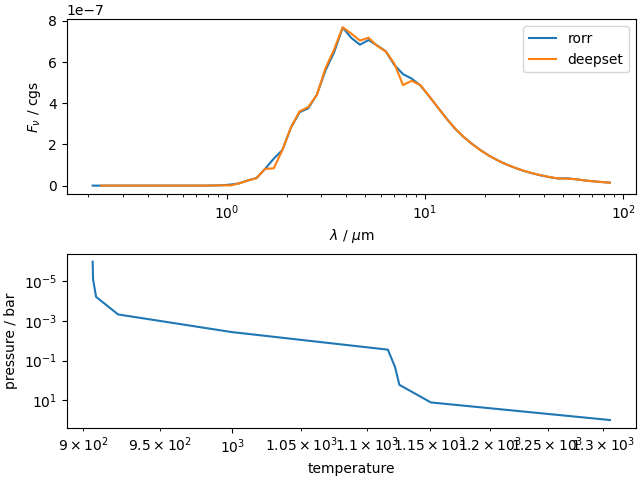

In [17]:
fig_fl, ax_fl = plt.subplots(2,1, constrained_layout=True)

@interact(gamma=FloatSlider(min=0.0, max=10.0, step=0.2, value=0.4), T_int=FloatSlider(min=0.,max=1000,step=100., value=100.), T_equ=FloatSlider(min=0.,max=2000.,step=100., value=1000.))
def plot_flux_toa(gamma, T_int, T_equ):
    for axi in ax_fl:
        axi.cla()
    
    kappa_IR = 0.05      
    Tstar=6000
    Rstar=1.0*nc.r_sun
    semimajoraxis=0.01*nc.AU
    gravity = 1e1**2.45
    geometry='dayside_ave'

    # temperature = chubb.Tr
    temperature = guillot_global(pressures, kappa_IR, gamma, gravity, T_int, T_equ)

    COs = 0.55 * np.ones_like(pressures)
    FeHs = 0. * np.ones_like(pressures)

    mass_fractions = interpol_abundances(COs, \
                FeHs, \
                temperature, \
                pressures)

    for sp in linespecies:
        mass_fractions[sp] = mass_fractions.pop(sp.split('_')[0])            

    bols = []
    for atmosphere, mixm in zip(atmospheres, mixmethods):
        atmosphere.calc_flux(temperature, mass_fractions, gravity, mass_fractions['MMW'], Rstar=Rstar, Tstar=Tstar, semimajoraxis=semimajoraxis, geometry=geometry)
        bol = np.sum(atmosphere.flux*np.diff(atmosphere.border_freqs))
        bols.append(bol)

    bols = np.array(bols)

    print('relative bolometric error on calculated flux:', (bols[0]-bols[:])/bols[0])

    for atmosphere, mixm in zip(atmospheres, mixmethods):
        ax_fl[0].plot(nc.c/atmosphere.freq*1e4, atmosphere.flux, label = mixm)

    ax_fl[0].set_xscale('log')
    ax_fl[0].set_xlabel(r'$\lambda$ / $\mu$m')
    ax_fl[0].set_ylabel(r'$F_\nu$ / cgs')
    ax_fl[1].loglog(temperature, pressures)
    ax_fl[1].set_ylabel(r'pressure / bar')
    ax_fl[1].set_xlabel('temperature')
    ax_fl[1].invert_yaxis()
    ax_fl[0].legend()


## Bolometric fluxes and heating rates

interactive(children=(FloatSlider(value=0.4, description='gamma', max=10.0, step=0.2), FloatSlider(value=100.0…

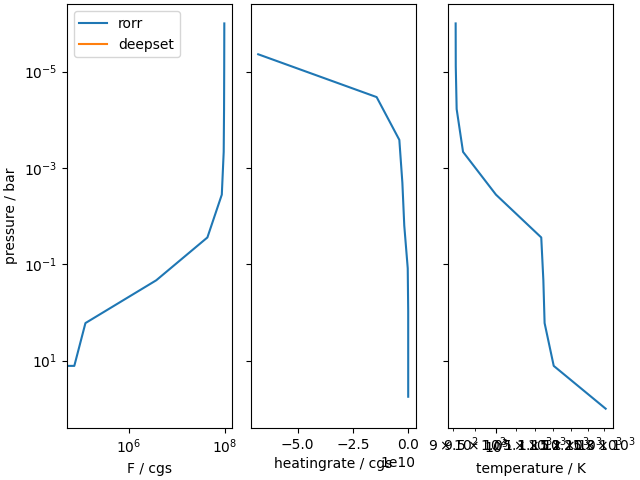

In [18]:
fig_flb, ax_flb = plt.subplots(1, 3, sharey= True, constrained_layout=True)

@interact(gamma=FloatSlider(min=0.0, max=10.0, step=0.2, value=0.4), T_int=FloatSlider(min=0.,max=1000,step=100., value=100.), T_equ=FloatSlider(min=0.,max=2000.,step=100., value=1000.))
def plot_flux_bol(gamma, T_int, T_equ):
    for axi in ax_flb:
        axi.cla()
    
    kappa_IR = 0.05      
    Tstar=6000
    Rstar=1.0*nc.r_sun
    semimajoraxis=0.01*nc.AU
    gravity = 1e1**2.45
    geometry='dayside_ave'

    # temperature = chubb.Tr
    temperature = guillot_global(pressures, kappa_IR, gamma, gravity, T_int, T_equ)

    COs = 0.55 * np.ones_like(pressures)
    FeHs = 0. * np.ones_like(pressures)

    mass_fractions = interpol_abundances(COs, \
                FeHs, \
                temperature, \
                pressures)

    for sp in linespecies:
        mass_fractions[sp] = mass_fractions.pop(sp.split('_')[0])            

    times = []
    for atmosphere, mixm in zip(atmospheres, mixmethods):
        atmosphere.calc_bolometric_flux(temperature, mass_fractions, gravity, mass_fractions['MMW'], Rstar=Rstar, Tstar=Tstar, semimajoraxis=semimajoraxis, geometry=geometry)

        p_e = atmosphere.press/1e6
        p_c = .5*(p_e[1:]+p_e[:-1])

        ax_flb[0].plot(atmosphere.flux_bol, p_e, label =mixm)
        ax_flb[1].plot(np.diff(atmosphere.flux_bol)/np.diff(p_e), p_c, label =mixm)

        times.append(atmosphere.time_opa)

    times = np.array(times)


    ax_flb[2].loglog(temperature, pressures)
    ax_flb[1].set_yscale('log')
    ax_flb[0].set_yscale('log')
    ax_flb[0].set_xscale('log')
    ax_flb[0].set_xlabel('F / cgs')
    ax_flb[1].set_xlabel('heatingrate / cgs')
    ax_flb[2].set_xlabel('temperature / K')
    ax_flb[0].set_ylabel('pressure / bar')
    # ax_fl[1].set_xscale('log')
    ax_flb[1].invert_yaxis()
    ax_flb[2].invert_yaxis()
    ax_flb[0].invert_yaxis()
    ax_flb[0].legend()

    print('times: 1st, fake, speedup',times[0], times, times[0]/times)


## Kappas

interactive(children=(FloatSlider(value=0.4, description='gamma', max=10.0, step=0.2), FloatSlider(value=100.0…

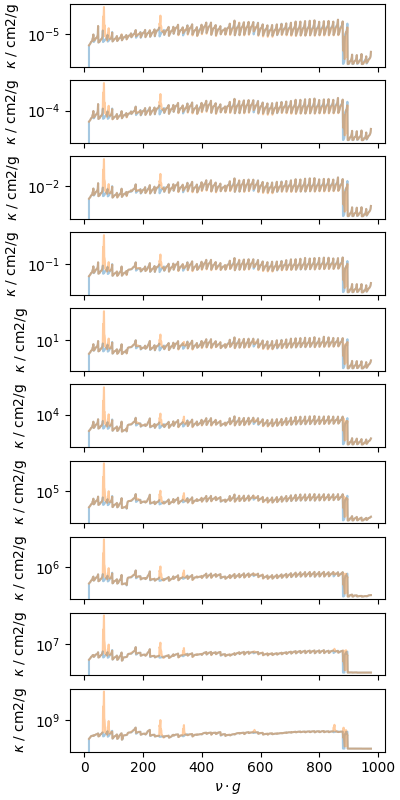

In [19]:
fig_kappa, ax_kappa = plt.subplots(10,1, figsize = (4,8), constrained_layout=True, sharex=True)

@interact(gamma=FloatSlider(min=0.0, max=10.0, step=0.2, value=0.4), T_int=FloatSlider(min=0.,max=1000,step=100., value=100.), T_equ=FloatSlider(min=0.,max=2000.,step=100., value=1000.))
def plot_eq_chem(gamma, T_int, T_equ):
    for axi in ax_kappa:
        axi.cla()  
    
    kappa_IR = 0.05      
    Tstar=6000
    Rstar=1.0*nc.r_sun
    semimajoraxis=0.01*nc.AU
    gravity = 1e1**2.45
    geometry='dayside_ave'

    # temperature = chubb.Tr
    temperature = guillot_global(pressures, kappa_IR, gamma, gravity, T_int, T_equ)

    COs = 0.55 * np.ones_like(pressures)
    FeHs = 0. * np.ones_like(pressures)

    mass_fractions = interpol_abundances(COs, \
                FeHs, \
                temperature, \
                pressures)

    for sp in linespecies:
        mass_fractions[sp] = mass_fractions.pop(sp.split('_')[0])

    for atmosphere, mixm in zip(atmospheres, mixmethods):
        atmosphere.calc_flux(temperature, mass_fractions, gravity, mass_fractions['MMW'], Rstar=Rstar, Tstar=Tstar, semimajoraxis=semimajoraxis, geometry=geometry)
        line_struc_kappas = atmosphere.line_struc_kappas[:,:,0,:]

        for i, p in enumerate(atmosphere.press):
            ax_kappa[i].plot(line_struc_kappas[:,:,i].T.flatten(), alpha=0.4, label=mixm)
    
            ax_kappa[i].set_yscale('log')
            ax_kappa[i].set_ylabel("$\kappa$ / cm2/g")

    ax_kappa[-1].set_xlabel(r"$\nu\cdot g$")